In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas_gbq
#pip install pygraphviz
#import pygraphviz

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [3]:
Deals = 'TBiz BB Capped Advanced'

In [4]:
query = """
SELECT *
FROM `bcx-insights.telkom_customerexperience.orders_20190926_00_anon`
WHERE DEAL_DESC = '{}'
ORDER BY ORDER_CREATION_DATE, ACTION_CREATION_DATE, ORDER_ID_ANON
""".format(Deals)

In [5]:
query

"\nSELECT *\nFROM `bcx-insights.telkom_customerexperience.orders_20190926_00_anon`\nWHERE DEAL_DESC = 'TBiz BB Capped Advanced'\nORDER BY ORDER_CREATION_DATE, ACTION_CREATION_DATE, ORDER_ID_ANON\n"

In [6]:
orders_df = pd.read_gbq(query,
                project_id = 'bcx-insights',
                dialect = 'standard')

In [7]:
orders_df.tail(3)

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,CLOSE_DATE,OPEN_CLOSE_INDIC,SOURCE,ORDER_ID_ANON,ACCOUNT_NO_ANON,MSISDN_ANON,ORDER_ACTION_ID_ANON
7843,Done,2019-09-18 06:41:04+00:00,Done,HS,Hard Suspend,2019-09-18 06:41:04+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2019-09-18 23:59:59+00:00,2019-09-18 06:41:33+00:00,C,F,-3623129877457504494,9179685449604117757,-3746220542732778290,-3107359610750660354
7844,Done,2019-09-18 06:41:06+00:00,Done,HS,Hard Suspend,2019-09-18 06:41:05+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2019-09-18 23:59:59+00:00,2019-09-18 06:41:26+00:00,C,F,-4085417724732539719,9179685449604117757,486548533846911321,5149598645928986403
7845,Done,2019-09-18 06:41:14+00:00,Done,HS,Hard Suspend,2019-09-18 06:41:13+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2019-09-18 23:59:59+00:00,2019-09-18 06:41:23+00:00,C,F,-8459172821802969048,9179685449604117757,-3379634856020541348,7366941129127761236


In [8]:
len(orders_df)

7846

In [9]:
orders_df = orders_df.drop_duplicates()

In [10]:
len(orders_df)

6816

In [11]:
orders_df['MSISDN_ANON'] = orders_df['MSISDN_ANON'].astype(str)

In [12]:
orders_df['ORDER_ID_ANON'] = orders_df['ORDER_ID_ANON'].astype(str)

In [13]:
unique_col = 'combo'

In [14]:
orders_df[unique_col] = orders_df['MSISDN_ANON']+'_'+orders_df['ORDER_ID_ANON']

In [15]:
orders_df['stage'] = orders_df.groupby(unique_col).cumcount()+1

In [16]:
final_stage = orders_df[[unique_col,'stage', 'ORDER_CREATION_DATE']].groupby(unique_col).agg({'stage': 'max', 'ORDER_CREATION_DATE': ['min', 'max']})

In [17]:
final_stage.head()

stage       ORDER_CREATION_DATE  \
                                            max                       min   
combo                                                                       
-1002689210467033689_-4097911263059863394     2 2019-06-10 13:55:28+00:00   
-1002689210467033689_-4708518482210045078     1 2019-06-10 13:44:49+00:00   
-1002689210467033689_-6805338612372424491     1 2019-08-29 06:26:56+00:00   
-1002689210467033689_4694949585886651643      1 2019-07-16 02:47:00+00:00   
-1002689210467033689_6330235094427327840      1 2019-08-29 10:21:36+00:00   

                                                                     
                                                                max  
combo                                                                
-1002689210467033689_-4097911263059863394 2019-07-02 10:07:27+00:00  
-1002689210467033689_-4708518482210045078 2019-06-10 13:44:49+00:00  
-1002689210467033689_-6805338612372424491 2019-08-29 06:26:56+00:00  
-1002689210467033689_4694949585886651643  2019-07-16 02:47:00+00:00  
-1002689210467033689_6330235094427327840  2019-08-29 10:21:36+00:00

In [18]:
final_stage.columns = ["_".join(pair) for pair in final_stage.columns]

In [19]:
#final_stage.columns = final_stage.columns.droplevel()

In [20]:
final_stage.rename(columns={'stage_max':'final_stage', 'ORDER_CREATION_DATE_min':'first_date', 'ORDER_CREATION_DATE_max':'last_date'}, inplace=True)

In [21]:
final_stage.head()

,final_stage,first_date,last_date
combo,,,
-1002689210467033689_-4097911263059863394,2,2019-06-10 13:55:28+00:00,2019-07-02 10:07:27+00:00
-1002689210467033689_-4708518482210045078,1,2019-06-10 13:44:49+00:00,2019-06-10 13:44:49+00:00
-1002689210467033689_-6805338612372424491,1,2019-08-29 06:26:56+00:00,2019-08-29 06:26:56+00:00
-1002689210467033689_4694949585886651643,1,2019-07-16 02:47:00+00:00,2019-07-16 02:47:00+00:00
-1002689210467033689_6330235094427327840,1,2019-08-29 10:21:36+00:00,2019-08-29 10:21:36+00:00


In [22]:
orders_df = pd.merge(orders_df, final_stage, on=unique_col, how='outer')

In [23]:
orders_df.head()

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,...,SOURCE,ORDER_ID_ANON,ACCOUNT_NO_ANON,MSISDN_ANON,ORDER_ACTION_ID_ANON,combo,stage,final_stage,first_date,last_date
0,Done,2018-09-19 00:01:40+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:00:34+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,...,F,8014743664010143874,4880988462641041588,8267334465643049670,-22945164240823800,8267334465643049670_8014743664010143874,1,1,2018-09-19 00:01:40+00:00,2018-09-19 00:01:40+00:00
1,Done,2018-09-19 00:08:19+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:02:30+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,...,F,4896610020755115874,4880988462641041588,5883010122451860359,6206333873489587611,5883010122451860359_4896610020755115874,1,1,2018-09-19 00:08:19+00:00,2018-09-19 00:08:19+00:00
2,Done,2018-09-19 00:08:22+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:08:04+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,...,F,-7402119597778060068,-7190704940419402037,6881390640784013810,1589287855847731834,6881390640784013810_-7402119597778060068,1,1,2018-09-19 00:08:22+00:00,2018-09-19 00:08:22+00:00
3,Done,2018-09-19 00:11:18+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:11:16+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,...,F,-891254573908734095,-1202927280942112478,-7917274003366893655,7874500299927321830,-7917274003366893655_-891254573908734095,1,1,2018-09-19 00:11:18+00:00,2018-09-19 00:11:18+00:00
4,Done,2018-09-19 00:11:26+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:11:25+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,...,F,-4980229336441433325,-1202927280942112478,-3858268071889160291,-6140598406575839500,-3858268071889160291_-4980229336441433325,1,1,2018-09-19 00:11:26+00:00,2018-09-19 00:11:26+00:00


In [24]:
orders_df['total_time'] = orders_df['ORDER_CREATION_DATE']-orders_df['first_date']

In [25]:
orders_df[orders_df['final_stage']==2].head()

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,...,ORDER_ID_ANON,ACCOUNT_NO_ANON,MSISDN_ANON,ORDER_ACTION_ID_ANON,combo,stage,final_stage,first_date,last_date,total_time
52,Cancelled,2018-09-19 10:20:39+00:00,Cancelled,CI,Cease Part Of Migrate,2018-09-19 00:00:00+00:00,Call Center,Call Center,TBiz BB Capped Advanced,1950-01-01 00:00:00+00:00,...,-798146561363310271,6512472196967755422,-163301983679457663,8269386966561002079,-163301983679457663_-798146561363310271,1,2,2018-09-19 10:20:39+00:00,2018-09-19 10:41:39+00:00,0 days 00:00:00
53,Done,2018-09-19 10:41:39+00:00,Done,CI,Cease Part Of Migrate,2018-09-19 00:00:00+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 12:41:55+00:00,...,-798146561363310271,6512472196967755422,-163301983679457663,-8038438834520941868,-163301983679457663_-798146561363310271,2,2,2018-09-19 10:20:39+00:00,2018-09-19 10:41:39+00:00,0 days 00:21:00
147,Cancelled,2018-09-21 15:00:41+00:00,Cancelled,CI,Cease Part Of Migrate,2018-09-21 00:00:00+00:00,WNS SMBS Outbound,WNS SMBS Outbound,TBiz BB Capped Advanced,1950-01-01 00:00:00+00:00,...,1927791018406881593,8730648574707157456,-5476603457303044367,-6211388984143561759,-5476603457303044367_1927791018406881593,1,2,2018-09-21 15:00:41+00:00,2018-09-25 12:46:42+00:00,0 days 00:00:00
148,Done,2018-09-25 12:46:42+00:00,Done,CI,Cease Part Of Migrate,2018-09-21 00:00:00+00:00,WNS SMBS Outbound,WNS SMBS Outbound,TBiz BB Capped Advanced,2018-09-25 13:18:32+00:00,...,1927791018406881593,8730648574707157456,-5476603457303044367,-7765968125154275429,-5476603457303044367_1927791018406881593,2,2,2018-09-21 15:00:41+00:00,2018-09-25 12:46:42+00:00,3 days 21:46:01
274,Cancelled,2018-09-26 13:38:57+00:00,Cancelled,CH,Change,2018-09-26 00:00:00+00:00,Telkom Direct Shop,Telkom Direct Shop,TBiz BB Capped Advanced,1950-01-01 00:00:00+00:00,...,1311839235413350640,-5526670356510072085,-1737832741425107573,1353844975755891999,-1737832741425107573_1311839235413350640,1,2,2018-09-26 13:38:57+00:00,2018-10-02 13:58:35+00:00,0 days 00:00:00


In [26]:
orders_df['stage'] = orders_df['stage'].astype(str)

In [27]:
orders_df['ActionType_OrderStatus'] = orders_df['ACTION_TYPE_DESC'] +' * '+ orders_df['ORDER_STATUS_DESC'] 

In [28]:
type_status = list(orders_df['ActionType_OrderStatus'].unique())

In [29]:
orders_df['stage_ActionType_OrderStatus'] = orders_df['stage'] +') * '+ orders_df['ACTION_TYPE_DESC'] +' * '+ orders_df['ORDER_STATUS_DESC'] 

In [30]:
orders_df.tail(3)

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,...,MSISDN_ANON,ORDER_ACTION_ID_ANON,combo,stage,final_stage,first_date,last_date,total_time,ActionType_OrderStatus,stage_ActionType_OrderStatus
6813,Done,2019-09-18 06:41:04+00:00,Done,HS,Hard Suspend,2019-09-18 06:41:04+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2019-09-18 23:59:59+00:00,...,-3746220542732778290,-3107359610750660354,-3746220542732778290_-3623129877457504494,1,1,2019-09-18 06:41:04+00:00,2019-09-18 06:41:04+00:00,0 days,Hard Suspend * Done,1) * Hard Suspend * Done
6814,Done,2019-09-18 06:41:06+00:00,Done,HS,Hard Suspend,2019-09-18 06:41:05+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2019-09-18 23:59:59+00:00,...,486548533846911321,5149598645928986403,486548533846911321_-4085417724732539719,1,1,2019-09-18 06:41:06+00:00,2019-09-18 06:41:06+00:00,0 days,Hard Suspend * Done,1) * Hard Suspend * Done
6815,Done,2019-09-18 06:41:14+00:00,Done,HS,Hard Suspend,2019-09-18 06:41:13+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2019-09-18 23:59:59+00:00,...,-3379634856020541348,7366941129127761236,-3379634856020541348_-8459172821802969048,1,1,2019-09-18 06:41:14+00:00,2019-09-18 06:41:14+00:00,0 days,Hard Suspend * Done,1) * Hard Suspend * Done


In [31]:
#orders_df.groupby(unique_col)

In [32]:
customers = list(orders_df[unique_col].unique())

In [33]:
sorted_df = orders_df.sort_values('stage', ascending=False)
sorted_df.head(3)

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,...,MSISDN_ANON,ORDER_ACTION_ID_ANON,combo,stage,final_stage,first_date,last_date,total_time,ActionType_OrderStatus,stage_ActionType_OrderStatus
336,Done,2018-11-20 10:10:17+00:00,Done,MS,Move Outdoor Same Exchange,2018-08-27 00:00:00+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-11-20 10:11:40+00:00,...,-5358406379613644979,-8130465519461665528,-5358406379613644979_4892878901532782903,4,4,2018-09-28 10:44:38+00:00,2018-11-20 10:10:17+00:00,52 days 23:25:39,Move Outdoor Same Exchange * Done,4) * Move Outdoor Same Exchange * Done
410,Done,2018-10-09 14:54:01+00:00,Done,MV,Move Outdoor Other Exchange,2018-10-02 00:00:00+00:00,Consumer Sales,Consumer Sales,TBiz BB Capped Advanced,2018-10-09 14:56:37+00:00,...,3842282672409691663,-4311406567201441950,3842282672409691663_4834273730448523809,4,4,2018-10-02 14:54:19+00:00,2018-10-09 14:54:01+00:00,6 days 23:59:42,Move Outdoor Other Exchange * Done,4) * Move Outdoor Other Exchange * Done
588,Done,2018-10-10 13:54:29+00:00,Done,PR,Provide,2018-10-10 00:00:00+00:00,Deregulated PABX Suppliers,Deregulated PABX Suppliers,TBiz BB Capped Advanced,2018-10-10 13:55:45+00:00,...,5100925659296341771,7122014269109539755,5100925659296341771_-152669041816858573,4,4,2018-10-10 13:43:57+00:00,2018-10-10 13:54:29+00:00,0 days 00:10:32,Provide * Done,4) * Provide * Done


In [34]:
len(orders_df[orders_df['stage']=='2'])

157

In [35]:
len(customers)

6650

In [36]:
# Create a networkx graph object
J = nx.Graph()

In [37]:
J.clear()

In [38]:
max_stage=max(orders_df['stage'].astype(int))
max_stage

4

In [39]:
actions = list(orders_df['stage_ActionType_OrderStatus'].unique())

In [40]:
J.add_node(Deals[:3],posi=(0.4,10), color = 'purple', acc_time = 0, node_count = 1)

In [41]:
for i in range(1,max_stage+1):
  
  stage_actions = list(orders_df[orders_df['stage']==str(i)]['stage_ActionType_OrderStatus'].unique())
  #print(stage_actions)
  for k in range(len(stage_actions)):
    label = stage_actions[k]
    #print(label)
    #print(len(orders_df[orders_df['stage_ActionType_OrderStatus']==label]))
    label = label.split('* ',1)
    label = label[1]
    #print(label)
    height =  type_status.index(label) +1
    #print(height)
    #print(height)
    J.add_node(stage_actions[k],posi=(i*1.25,height), acc_time = 0, node_count = len(orders_df[orders_df['stage_ActionType_OrderStatus']==stage_actions[k]]))
    #print(stage_actions[k])
    #print((i,k+1))

In [42]:
J.nodes(data = True)

NodeDataView({'4) * Move Outdoor Other Exchange * Done': {'posi': (5.0, 22), 'acc_time': 0, 'node_count': 1}, '1) * Change * Done': {'posi': (1.25, 16), 'acc_time': 0, 'node_count': 14}, '1) * Move Outdoor Same Exchange * Cancelled': {'posi': (1.25, 14), 'acc_time': 0, 'node_count': 12}, '2) * Receive  Ownership * Done': {'posi': (2.5, 6), 'acc_time': 0, 'node_count': 2}, '1) * Change - Dispatchable * Cancelled': {'posi': (1.25, 5), 'acc_time': 0, 'node_count': 16}, '3) * Provide * Cancelled': {'posi': (3.75, 25), 'acc_time': 0, 'node_count': 2}, '1) * Provide * Done': {'posi': (1.25, 12), 'acc_time': 0, 'node_count': 51}, '1) * Change BAN To BAN * Done': {'posi': (1.25, 39), 'acc_time': 0, 'node_count': 4}, '2) * Move Outdoor Same Exchange * Cancelled': {'posi': (2.5, 14), 'acc_time': 0, 'node_count': 2}, '1) * Receive  Ownership * Done': {'posi': (1.25, 6), 'acc_time': 0, 'node_count': 30}, '1) * Provide Part Of Migrate * Cancelled': {'posi': (1.25, 30), 'acc_time': 0, 'node_count': 

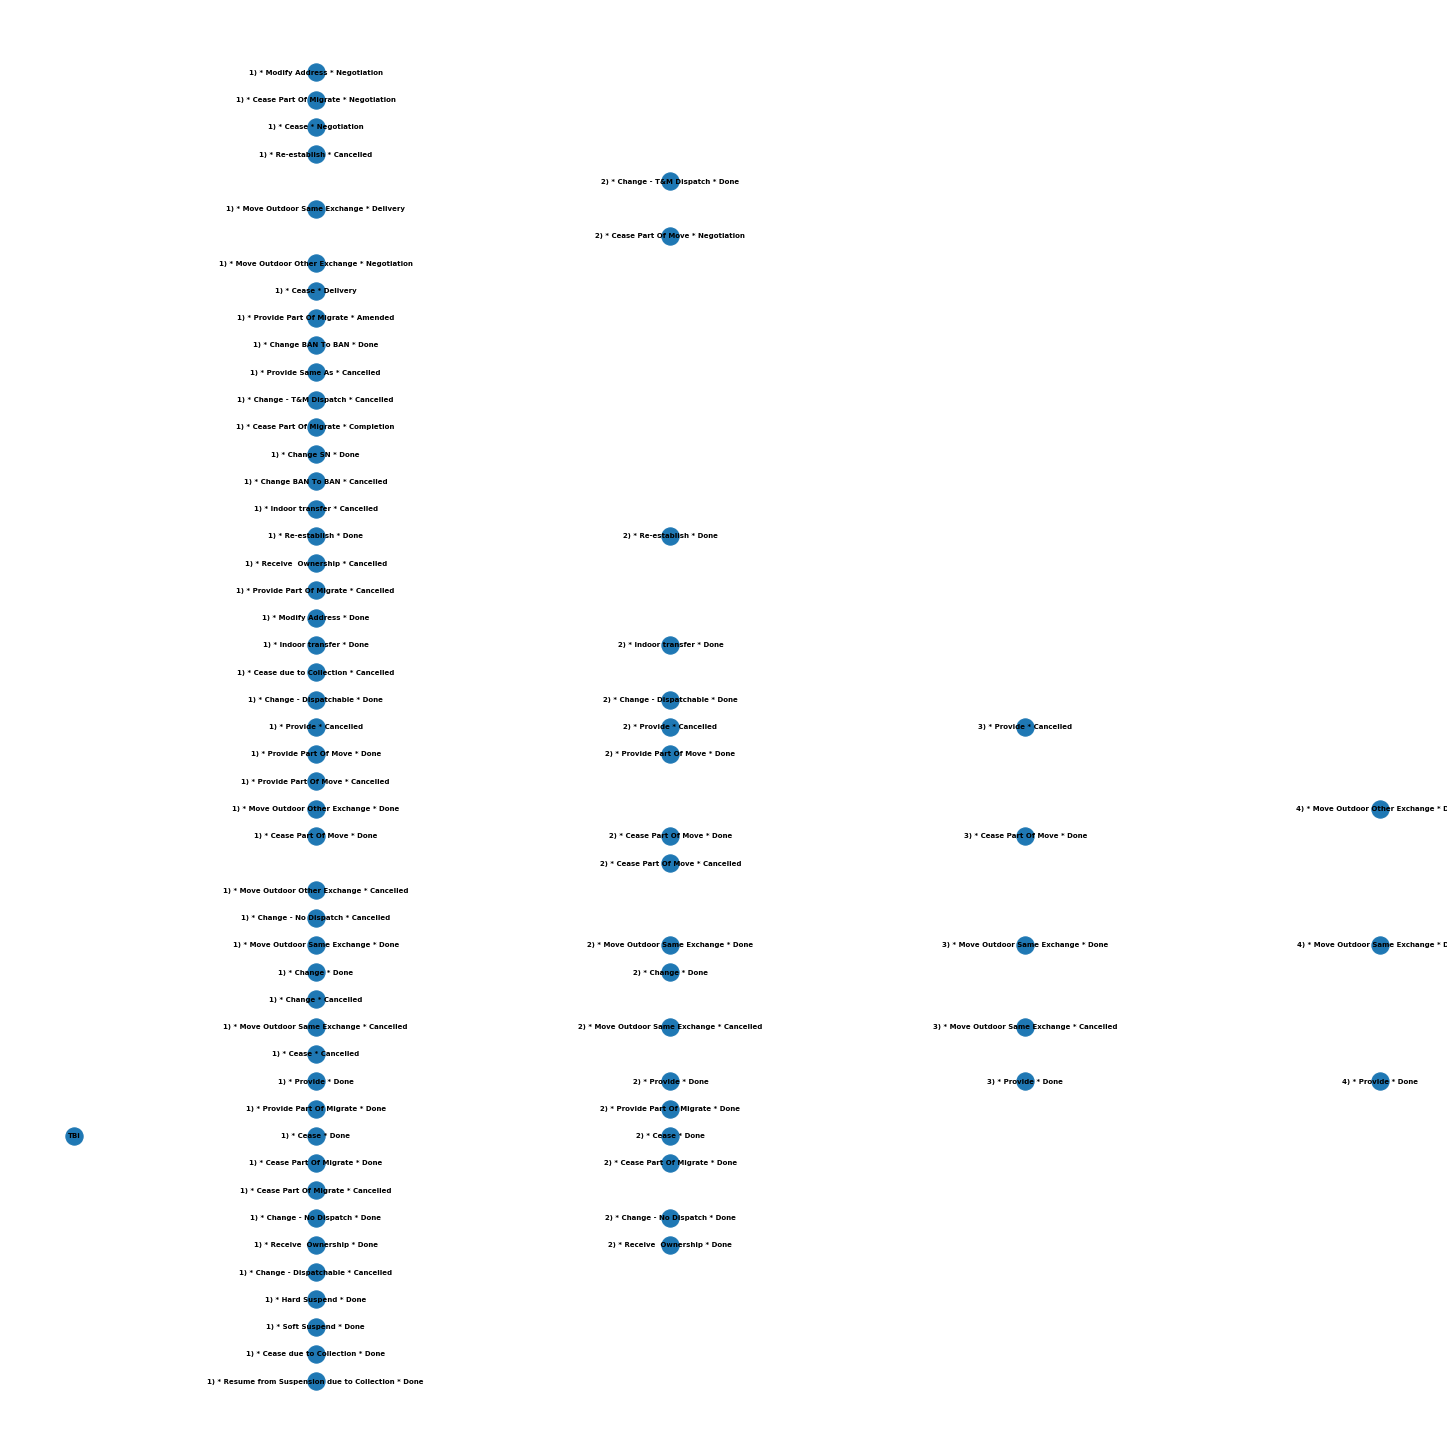

In [43]:
# Draw the resulting graph
pos = nx.get_node_attributes(J,'posi')
nx.draw(J, pos ,with_labels=True, font_weight='bold', font_size = 7)
plt.show()

In [44]:
# clear edges
J.remove_edges_from(list(J.edges()))

In [45]:
#create edges with data (count, days, ave_days)
# accumulated time for nodes

date_col = orders_df.columns.get_loc('ORDER_CREATION_DATE')
kpi = 5

for c in customers:

    temp_df = orders_df[orders_df[unique_col] == c]
  
    for i in range(len(temp_df)-1):
        #print(i, c)
        if J.has_edge(temp_df.iloc[i, -1], temp_df.iloc[(i+1),-1]) == False:
            #print(temp_df.iloc[i, -1], temp_df.iloc[(i+1),-1])
            #print(temp_df.iloc[i,-4], temp_df.iloc[(i+1),-4])
            J.add_edge(temp_df.iloc[i, -1], temp_df.iloc[(i+1),-1])
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count'] = 1
            difference = (temp_df.iloc[(i+1),date_col]-temp_df.iloc[i, date_col])
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days'] = round(difference.total_seconds()/(60*60*24),1)
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['ave_days'] = round(J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days']/ J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count'],1)
            
            acc_current = J.node[temp_df.iloc[(i+1),-1]]['acc_time']
            J.node[temp_df.iloc[(i+1),-1]]['acc_time'] = round(acc_current + temp_df.iloc[(i+1),-3].total_seconds()/(60*60*24),1) #-3 is total_time
            #J.node[temp_df.iloc[(i+1),-1]]['node_count'] += 1
            
            
            if J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['ave_days'] > kpi:
                J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['color'] = 'red'
            else:
                J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['color'] = 'green'

        else:
            current_count = J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count']
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count'] = current_count + 1

            current_days =  J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days']
            difference = (temp_df.iloc[(i+1),date_col]-temp_df.iloc[i, date_col])
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days'] = round(current_days + difference.total_seconds()/(60*60*24),1)

            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['ave_days'] = round(J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days']/ J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count'],1)
            
            acc_current = J.node[temp_df.iloc[(i+1),-1]]['acc_time']
            J.node[temp_df.iloc[(i+1),-1]]['acc_time'] = round(acc_current + temp_df.iloc[(i+1),-3].total_seconds()/(60*60*24),1) #-3 is total_time         
            #J.node[temp_df.iloc[(i+1),-1]]['node_count'] += 1
            
            if J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['ave_days'] > kpi:
                J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['color'] = 'red'
            else:
                J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['color'] = 'green'


In [46]:
for j in J.nodes:
    #print(j)
    #print(J.node[j]['acc_time'])
    #print(J.node[j]['node_count'])
    J.node[j]['ave_journey'] = round(J.node[j]['acc_time']/J.node[j]['node_count'],1)
    

In [47]:
# add edge weight attribute

all_counts = []

#Iterate through the graph edges to gather all the weights
for (node1,node2,data) in J.edges(data=True):
    all_counts.append(data['count']) 

    
total_count = sum(all_counts)
max_count = max(all_counts)
min_count = min(all_counts)
ave_count = total_count/len(all_counts)
scale = 14

print('Total Counts',total_count)
print('Max Count',max_count)
print('Min Count', min_count)
print('Ave Count',ave_count)


if (max_count-min_count) == 0:
    for (node1,node2,data) in J.edges(data=True):
        J.edges[node1,node2]['weight'] = round(J.edges[node1,node2]['count'],1)

else:                                                
    for (node1,node2,data) in J.edges(data=True):
        J.edges[node1,node2]['weight'] = round(((J.edges[node1,node2]['count']-min_count)/(max_count-min_count))*scale+1,1)
    

Total Counts 166
Max Count 102
Min Count 1
Ave Count 5.928571428571429


In [48]:
J.edges(data=True)

EdgeDataView([('4) * Move Outdoor Other Exchange * Done', '3) * Cease Part Of Move * Done', {'ave_days': 0.0, 'days': 0.0, 'weight': 1.0, 'color': 'green', 'count': 1}), ('1) * Move Outdoor Same Exchange * Cancelled', '2) * Move Outdoor Same Exchange * Done', {'ave_days': 30.0, 'days': 89.9, 'weight': 1.3, 'color': 'red', 'count': 3}), ('1) * Move Outdoor Same Exchange * Cancelled', '2) * Move Outdoor Same Exchange * Cancelled', {'ave_days': 10.5, 'days': 21.0, 'weight': 1.1, 'color': 'red', 'count': 2}), ('2) * Re-establish * Done', '1) * Re-establish * Cancelled', {'ave_days': 1.7, 'days': 1.7, 'weight': 1.0, 'color': 'green', 'count': 1}), ('2) * Receive  Ownership * Done', '1) * Receive  Ownership * Cancelled', {'ave_days': 16.0, 'days': 32.0, 'weight': 1.1, 'color': 'red', 'count': 2}), ('1) * Change - Dispatchable * Cancelled', '2) * Change - Dispatchable * Done', {'ave_days': 2.9, 'days': 2.9, 'weight': 1.0, 'color': 'green', 'count': 1}), ('3) * Provide * Cancelled', '2) * Prov

In [49]:
J.nodes(data = True)

NodeDataView({'4) * Move Outdoor Other Exchange * Done': {'posi': (5.0, 22), 'acc_time': 7.0, 'ave_journey': 7.0, 'node_count': 1}, '1) * Change * Done': {'posi': (1.25, 16), 'acc_time': 0, 'ave_journey': 0.0, 'node_count': 14}, '1) * Move Outdoor Same Exchange * Cancelled': {'posi': (1.25, 14), 'acc_time': 0, 'ave_journey': 0.0, 'node_count': 12}, '2) * Receive  Ownership * Done': {'posi': (2.5, 6), 'acc_time': 32.0, 'ave_journey': 16.0, 'node_count': 2}, '1) * Change - Dispatchable * Cancelled': {'posi': (1.25, 5), 'acc_time': 0, 'ave_journey': 0.0, 'node_count': 16}, '3) * Provide * Cancelled': {'posi': (3.75, 25), 'acc_time': 0.0, 'ave_journey': 0.0, 'node_count': 2}, '1) * Provide * Done': {'posi': (1.25, 12), 'acc_time': 0, 'ave_journey': 0.0, 'node_count': 51}, '1) * Change BAN To BAN * Done': {'posi': (1.25, 39), 'acc_time': 0, 'ave_journey': 0.0, 'node_count': 4}, '2) * Move Outdoor Same Exchange * Cancelled': {'posi': (2.5, 14), 'acc_time': 21.0, 'ave_journey': 10.5, 'node_co

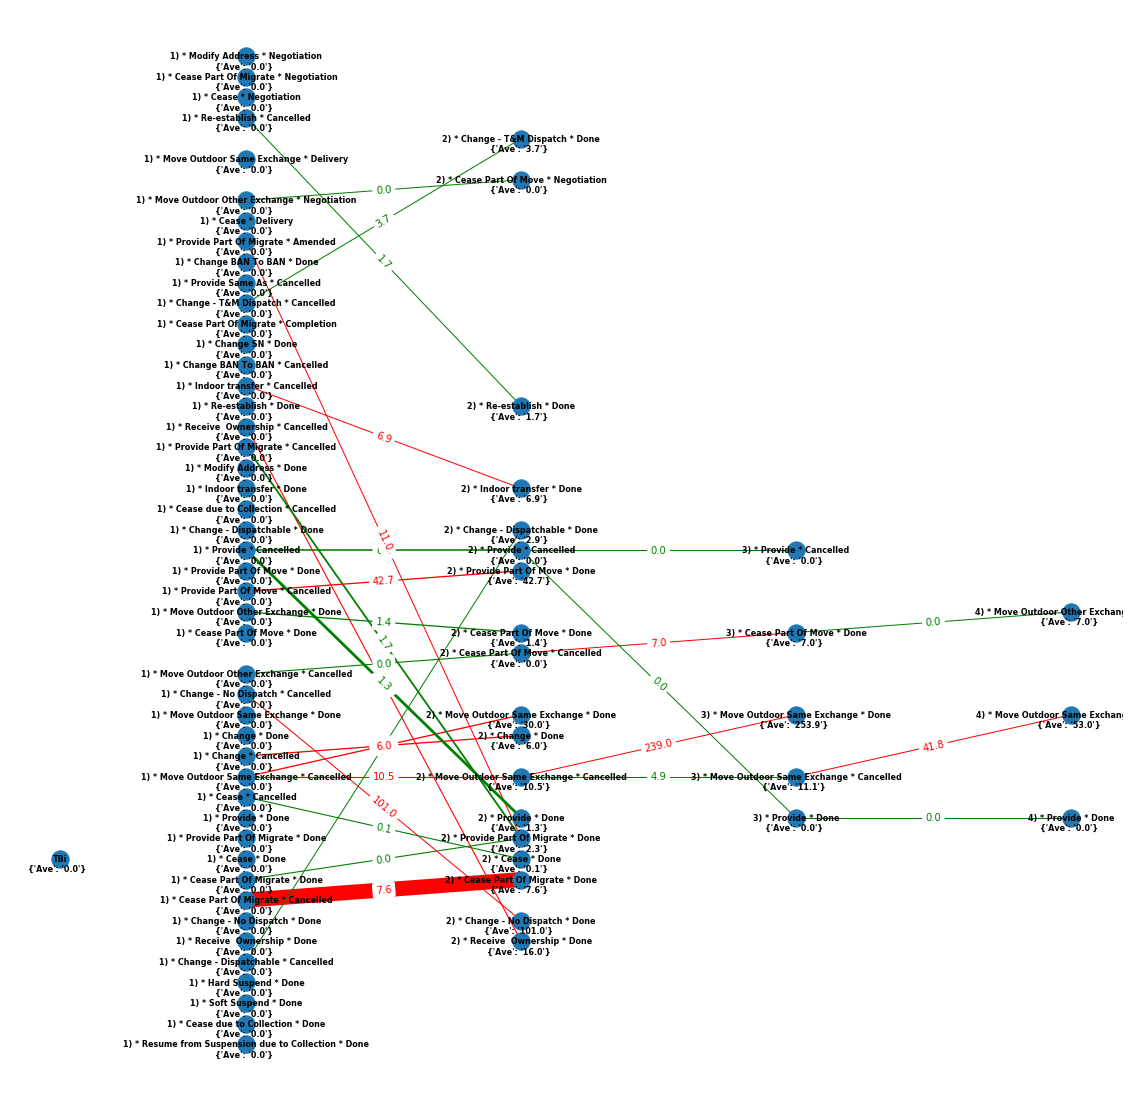

In [61]:
# Draw the resulting graph

#mpl_fig = plt.figure()
mpl_fig, ax = plt.subplots(1,1)

#pos = nx.circular_layout(J)
pos = nx.get_node_attributes(J,'posi')
edges,colors = zip(*nx.get_edge_attributes(J,'color').items())
edges,width = zip(*nx.get_edge_attributes(J,'weight').items())


nx.draw(J,pos, ax=ax, with_labels=True, font_weight='bold', font_size = 8, edgelist=edges, edge_color=colors, width = width
       )

edge_labels  = nx.get_edge_attributes(J,'ave_days')
#label_color  = nx.get_edge_attributes(J,'color').values()

#print(pos)

for e in J.edges(data=True):
    #print(e)
    #print(e[0])
    #print(e[1])
    #print(e[2])
    #print(e[2]['color'])
    nx.draw_networkx_edge_labels(J,ax=ax, pos=pos,edge_labels={(e[0],e[1]):e[2]['ave_days']}, font_color = e[2]['color'])
    

pos_attrs = {}
for node, coords in pos.items():
    pos_attrs[node] = (coords[0] - 0.01, coords[1] - 0.5)

node_attrs = nx.get_node_attributes(J, 'ave_journey')
custom_node_attrs = {}
for node, attr in node_attrs.items():
    custom_node_attrs[node] = "{'Ave': '" + str(attr) + "'}"

nx.draw_networkx_labels(J, pos_attrs, labels=custom_node_attrs, font_weight='bold', font_size = 8)

plt.savefig('stage_transition_edge_colour')
plt.show()

In [ ]:
type(mpl_fig)

In [ ]:
mpl_fig

In [ ]:
#pip install dash==1.4.1

In [ ]:
#pip install chart_studio

In [ ]:
import chart_studio.plotly as py
from plotly.tools import mpl_to_plotly
import dash_core_components as dcc


In [ ]:
import ipywidgets

In [ ]:
plotly_fig = mpl_to_plotly(mpl_fig)

In [ ]:
plotly_fig

In [ ]:
graph = dcc.Graph(id='myGraph', figure=plotly_fig)  # figure not fig 

In [ ]:
graph

In [ ]:
# Draw the resulting graph
#pos = nx.circular_layout(J)
pos = nx.get_node_attributes(J,'posi')
nx.draw(J,pos, with_labels=True, font_size = 7
        #, arrowstyle='->',arrowsize=15
       )

edge_labels = nx.get_edge_attributes(J, 'count')
nx.draw_networkx_edge_labels(J,pos,edge_labels=edge_labels,font_color='red')

plt.show()

In [ ]:
orders_df[orders_df['stage_ActionType_OrderStatus']=='2) * Cease Part Of Move * Cancelled']['MSISDN_ANON'].unique()

In [ ]:
#orders_df[orders_df['MSISDN_ANON']=='91450653458314736']